<a href="https://colab.research.google.com/github/asmik12/Coursework_UCLA/blob/main/ECE-M117-Intro-to-Computer-Security/part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 117 - Assignment 3: Part 3
The goal of this part of the assignment is to implement machine unlearning via fine-tuning.

In [41]:
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18

import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

RNG = torch.Generator().manual_seed(42)

Running on device: CPU


In [42]:
normalize = transforms.Compose([transforms.ToTensor()])

train_set = torchvision.datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=normalize
)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

held_out = torchvision.datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=normalize
)
test_set, val_set = torch.utils.data.random_split(held_out, [0.5, 0.5], generator=RNG)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2)

forget_class = 0
forget_idx, retain_idx = [], []
for i, target in enumerate(train_set.targets):
  if target == forget_class:
    forget_idx.append(i)
  else:
    retain_idx.append(i)

forget_set = torch.utils.data.Subset(train_set, forget_idx)
retain_set = torch.utils.data.Subset(train_set, retain_idx)

forget_loader = torch.utils.data.DataLoader(
    forget_set, batch_size=128, shuffle=True, num_workers=2
)
retain_loader = torch.utils.data.DataLoader(
    retain_set, batch_size=128, shuffle=True, num_workers=2, generator=RNG
)

In [43]:
# This is provided as a baseline model but feel free to adjust this.
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [44]:
model = CNN().to(DEVICE)

#i_max = 6400 #already there in starter code
i_max = 6400

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [45]:
@torch.no_grad()
def get_accuracy(model, data_loader, device):
    correct = 0
    total = 0

    for inputs, labels in data_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, dim=1)

        total += labels.shape[0]
        correct += int((predicted == labels).sum())

    return correct / total

In [46]:
# First, train a baseline FashionMNIST CNN

progress = tqdm.tqdm(total=i_max, desc="Training")

i = 0
while i < i_max:
    for inputs, labels in train_loader:
        # Add training loop here
        #FORWARD PASS
        #move inputs and labels to the device
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        #zero the gradients
        optimizer.zero_grad()

        #forward pass through the model
        outputs = model(inputs)

        #compute the loss
        loss = criterion(outputs, labels)

        #BACKWARD PASS
        #backpropogate the loss
        loss.backward()

        #update the model parameters
        optimizer.step()

        #end of training step

        i += 1
        progress.update(1)

        if i % 1000 == 0:
            train_acc = get_accuracy(model, train_loader, DEVICE)
            test_acc = get_accuracy(model, test_loader, DEVICE)
            progress.write(f"Iter {i} Train Acc {train_acc:.4f} Test Acc {test_acc:.4f}")

        if i >= i_max:
            break

torch.save(model.state_dict(), "./model.pth")


Training: 100%|██████████| 100/100 [01:43<00:00,  1.03s/it]

Training:  16%|█▌        | 998/6400 [00:47<03:44, 24.08it/s]

Training:  16%|█▌        | 1004/6400 [01:02<1:35:06,  1.06s/it]

Iter 1000 Train Acc 0.8479 Test Acc 0.8406



Training:  31%|███▏      | 2000/6400 [02:03<03:17, 22.27it/s]

Training:  31%|███▏      | 2004/6400 [02:06<1:33:27,  1.28s/it]

Iter 2000 Train Acc 0.8754 Test Acc 0.8650



Training:  47%|████▋     | 3000/6400 [03:13<04:21, 13.01it/s]

Training:  47%|████▋     | 3001/6400 [03:17<2:14:43,  2.38s/it]


Iter 3000 Train Acc 0.8841 Test Acc 0.8758


Training:  62%|██████▎   | 4000/6400 [04:24<01:51, 21.50it/s]

Training:  63%|██████▎   | 4004/6400 [04:27<50:47,  1.27s/it]  

Iter 4000 Train Acc 0.8972 Test Acc 0.8842



Training:  78%|███████▊  | 5000/6400 [05:34<01:05, 21.48it/s]

Training:  78%|███████▊  | 5003/6400 [05:38<32:42,  1.40s/it]

Iter 5000 Train Acc 0.9021 Test Acc 0.8862



Training:  94%|█████████▍| 6000/6400 [06:44<00:18, 21.21it/s]

Training:  94%|█████████▍| 6001/6400 [06:45<10:43,  1.61s/it]


Iter 6000 Train Acc 0.9084 Test Acc 0.8910


Training: 100%|██████████| 6400/6400 [07:07<00:00, 13.49it/s]

In [47]:
test_accuracy = get_accuracy(model, test_loader, DEVICE)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.8922


In [62]:
# Machine unlearning via fine-tuning
i_max = 1000 #choose this number

progress = tqdm.tqdm(total=i_max, desc="Training")

i = 0
while i < i_max:
    for inputs, labels in retain_loader:
        # modify loop to fine-tune model
        #FORWARD PASS
        #move inputs and labels to the device
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        #zero the gradients
        optimizer.zero_grad()

        #forward pass through the model
        outputs = model(inputs)

        #compute the loss
        loss = criterion(outputs, labels)

        #BACKWARD PASS
        #backpropogate the loss
        loss.backward()

        #update the model parameters
        optimizer.step()

        #end of training step

        i += 1
        progress.update(1)

        if i % 1000 == 0:
            train_acc = get_accuracy(model, train_loader, DEVICE)
            test_acc = get_accuracy(model, test_loader, DEVICE)
            progress.write(f"Iter {i} Train Acc {train_acc:.4f} Test Acc {test_acc:.4f}")

        if i >= i_max:
            break

torch.save(model.state_dict(), "./model-unlearned.pth")


Training: 100%|██████████| 6400/6400 [08:08<00:00, 13.09it/s]

Training: 100%|██████████| 1000/1000 [01:02<00:00, 22.45it/s]

Training: 100%|██████████| 1000/1000 [01:08<00:00, 22.45it/s]

Iter 1000 Train Acc 0.8450 Test Acc 0.8238


In [63]:
model_retain = CNN().to(DEVICE)

i_max = 6400

criterion_retain = torch.nn.CrossEntropyLoss()
optimizer_retain = torch.optim.Adam(model_retain.parameters(), lr=0.001, weight_decay=0.0001)

In [64]:
# Train only purely the retain set to benchmark

progress = tqdm.tqdm(total=i_max, desc="Training")

i = 0
while i < i_max:
    for inputs, labels in retain_loader:
        model_retain.train()

        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model_retain(inputs)
        loss = criterion_retain(outputs, labels)

        optimizer_retain.zero_grad()
        loss.backward()
        optimizer_retain.step()

        i += 1
        progress.update(1)

        if i % 1000 == 0:
            train_acc = get_accuracy(model_retain, retain_loader, DEVICE)
            test_acc = get_accuracy(model_retain, test_loader, DEVICE)
            progress.write(f"Iter {i} Train Acc {train_acc:.4f} Test Acc {test_acc:.4f}")

        if i >= i_max:
            break

torch.save(model_retain.state_dict(), "./model-retain.pth")

Training:  16%|█▌        | 1005/6400 [00:53<1:33:34,  1.04s/it]

Iter 1000 Train Acc 0.8625 Test Acc 0.7638


Training:  31%|███▏      | 2004/6400 [01:53<1:31:27,  1.25s/it]

Iter 2000 Train Acc 0.8868 Test Acc 0.7866


Training:  47%|████▋     | 3002/6400 [03:00<1:24:35,  1.49s/it]

Iter 3000 Train Acc 0.8947 Test Acc 0.7918


Training:  63%|██████▎   | 4004/6400 [04:04<46:13,  1.16s/it]  

Iter 4000 Train Acc 0.9071 Test Acc 0.8036


Training:  78%|███████▊  | 5004/6400 [05:07<28:52,  1.24s/it]

Iter 5000 Train Acc 0.9223 Test Acc 0.8164


Training:  94%|█████████▍| 6004/6400 [06:13<07:45,  1.18s/it]

Iter 6000 Train Acc 0.9123 Test Acc 0.8046


Training: 100%|██████████| 6400/6400 [06:33<00:00, 22.43it/s]

In [65]:
def compute_losses(net, loader):
    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        logits = net(inputs)
        losses = criterion(logits, targets).numpy(force=True)
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)


train_losses = compute_losses(model, train_loader)
test_losses = compute_losses(model, test_loader)

Training: 100%|██████████| 6400/6400 [06:44<00:00, 22.43it/s]

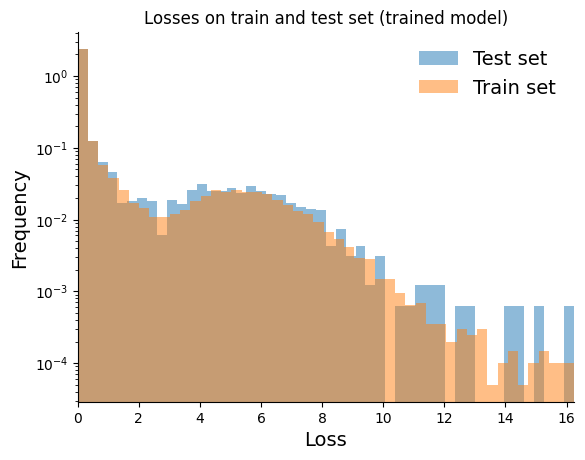

In [66]:
# plot losses on train and test set
plt.title("Losses on train and test set (trained model)")
plt.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
plt.hist(train_losses, density=True, alpha=0.5, bins=50, label="Train set")
plt.xlabel("Loss", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlim((0, np.max(test_losses)))
plt.yscale("log")
plt.legend(frameon=False, fontsize=14)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

In [67]:
def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

In [68]:
forget_losses = compute_losses(model, forget_loader)

# Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
np.random.shuffle(forget_losses)
forget_losses = forget_losses[: len(test_losses)]

samples_mia = np.concatenate((test_losses, forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(test_losses) + [1] * len(forget_losses)

mia_scores = simple_mia(samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {mia_scores.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.922 on forgotten vs unseen images


In [69]:
# Benchmark model purely on the retain set.

ft_forget_losses = compute_losses(model_retain, forget_loader)
ft_test_losses = compute_losses(model_retain, test_loader)

# make sure we have a balanced dataset for the MIA
ft_forget_losses = ft_forget_losses[: len(ft_test_losses)]
assert len(ft_test_losses) == len(ft_forget_losses)

ft_samples_mia = np.concatenate((ft_test_losses, ft_forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(ft_test_losses) + [1] * len(ft_forget_losses)

In [70]:
ft_mia_scores = simple_mia(ft_samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {ft_mia_scores.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.939 on forgotten vs unseen images


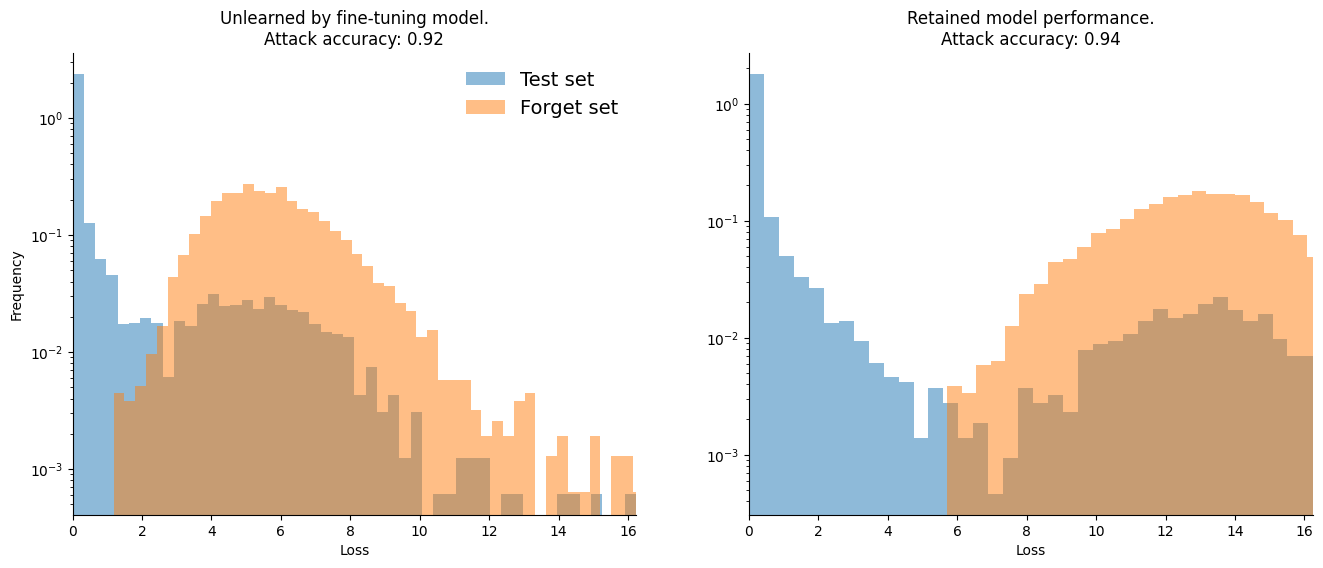

In [71]:
# Compare the results to determine the efficacy of the machine-unlearning implementation

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Unlearned by fine-tuning model.\nAttack accuracy: {mia_scores.mean():0.2f}")
ax1.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(
    f"Retained model performance.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
)
ax2.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(test_losses)))
ax2.set_xlim((0, np.max(test_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()